<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

In this lab, you will implement some of the techniques discussed in the lecture.

Below you are given a solution to the previous scenario. Note that it has two serious drawbacks:
 * The output predictions do not sum up to one (i.e. it does not return a distribution) even though the images always contain exactly one digit.
 * It uses MSE coupled with output sigmoid which can lead to saturation and slow convergence

**Task 1.** Use softmax instead of coordinate-wise sigmoid and use log-loss instead of MSE. Test to see if this improves convergence. Hint: When implementing backprop it might be easier to consider these two function as a single block and not even compute the gradient over the softmax values.

**Task 2.** Implement L2 regularization and add momentum to the SGD algorithm. Play with different amounts of regularization and momentum. See if this improves accuracy/convergence.

**Task 3 (optional).** Implement Adagrad, dropout and some simple data augmentations (e.g. tiny rotations/shifts etc.). Again, test to see how these changes improve accuracy/convergence.

**Task 4.** Try adding extra layers to the network. Again, test how the changes you introduced affect accuracy/convergence. As a start, you can try this architecture: [784,100,30,10]


In [ ]:
import random
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Let's read the mnist dataset

def load_mnist(path='.', augmentation: bool=True):
    if augmentation:
      transform = transforms.Compose([
          transforms.RandomRotation(15),
          transforms.RandomAffine(0, translate=(0.1, 0.1)),
          transforms.ToTensor()
      ])
    else:
      transform = transforms.ToTensors()

    train_set = datasets.MNIST(path, train=True, download=True, transform=transform)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()

    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()

    x_train = x_train.reshape((x_train.shape[0],28*28)) / 255.
    x_test = x_test.reshape((x_test.shape[0],28*28)) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15189100.15it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 469660.18it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4447301.22it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5611348.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [1]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

def softmax(z):
  z = np.exp(z)
  return z / np.sum(z, axis=0)

epsilon = 1e-8

Epoch: 0, Accuracy: 0.8329
Epoch: 1, Accuracy: 0.8892
Epoch: 2, Accuracy: 0.9124
Epoch: 3, Accuracy: 0.921
Epoch: 4, Accuracy: 0.9247
Epoch: 5, Accuracy: 0.9277
Epoch: 6, Accuracy: 0.9342
Epoch: 7, Accuracy: 0.9358
Epoch: 8, Accuracy: 0.9394
Epoch: 9, Accuracy: 0.9408
Epoch: 10, Accuracy: 0.9431
Epoch: 11, Accuracy: 0.9449
Epoch: 12, Accuracy: 0.9464
Epoch: 13, Accuracy: 0.9485
Epoch: 14, Accuracy: 0.9486
Epoch: 15, Accuracy: 0.9465
Epoch: 16, Accuracy: 0.9506
Epoch: 17, Accuracy: 0.9514
Epoch: 18, Accuracy: 0.9501
Epoch: 19, Accuracy: 0.9505
Epoch: 20, Accuracy: 0.9544
Epoch: 21, Accuracy: 0.9536
Epoch: 22, Accuracy: 0.9539
Epoch: 23, Accuracy: 0.9536
Epoch: 24, Accuracy: 0.9558
Epoch: 25, Accuracy: 0.956
Epoch: 26, Accuracy: 0.9559
Epoch: 27, Accuracy: 0.9557
Epoch: 28, Accuracy: 0.9595
Epoch: 29, Accuracy: 0.957
Epoch: 30, Accuracy: 0.956
Epoch: 31, Accuracy: 0.9577
Epoch: 32, Accuracy: 0.9582
Epoch: 33, Accuracy: 0.9584
Epoch: 34, Accuracy: 0.9573
Epoch: 35, Accuracy: 0.9601
Epoch:

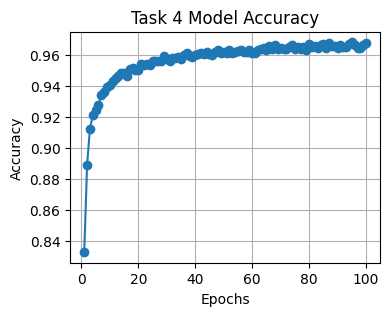

In [ ]:
class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        # Momentum
        self.momentum_w = [np.zeros_like(w) for w in self.weights]
        self.momentum_b = [np.zeros_like(b) for b in self.biases]
        # Adagrad
        self.G = [np.zeros_like(w) for w in self.weights]

    def feedforward(self, a, dropout_rate):
        # Run the network on a batch
        a = a.T

        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            a = sigmoid(np.matmul(w, a)+b) * (1 - dropout_rate)
        a = np.matmul(self.weights[-1], a) + self.biases[-1]
        a = softmax(a)
        return a

    def update_mini_batch(self, mini_batch, eta, gamma, lam, adagrad, dropout_rate):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T, dropout_rate)

        if adagrad:
            # Update G for Adagrad
            self.G = [g + np.power(nw, 2) for g, nw in zip(self.G, nabla_w)]

            # Apply Momentum and Adagrad update to weights
            self.momentum_w = [gamma * v - (eta / len(mini_batch[0])) * (nw / (np.sqrt(g) + epsilon))
                              for v, nw, g in zip(self.momentum_w, nabla_w, self.G)]
            self.momentum_b = [gamma * v - (eta / len(mini_batch[0])) * nb
                              for v, nb in zip(self.momentum_b, nabla_b)]

            # L2 Regularization (lam)
            self.weights = [(1 - eta * lam / len(mini_batch[0])) * w + v
                            for w, v in zip(self.weights, self.momentum_w)]
            self.biases = [b + v for b, v in zip(self.biases, self.momentum_b)]

        else:
            # Momentum (gamma)
            self.momentum_w = [gamma*v - (eta/len(mini_batch[0]))*nw
                            for v, nw in zip(self.momentum_w, nabla_w)]
            self.momentum_b = [gamma*v-(eta/len(mini_batch[0]))*nb
                          for v, nb in zip(self.momentum_b, nabla_b)]

            # L2 regularization (lam)
            self.weights = [w * (1- lam) + v for w, v in zip(self.weights, self.momentum_w)]
            self.biases = [b + v for b, v in zip(self.biases, self.momentum_b)]

    def backprop(self, x, y, dropout_rate):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        dropout_masks = []

        for i, (b, w) in enumerate(zip(self.biases[:-1], self.weights[:-1])):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)

            if dropout_rate > 0.0:
                dropout_mask = np.random.uniform(0, 1.0, g.shape) > dropout_rate
                g = np.multiply(g, dropout_mask)
                dropout_masks.append(dropout_mask)
            else:
                dropout_masks.append(None)

            gs.append(g)

        f = np.dot(self.weights[-1], g) + self.biases[-1]
        fs.append(f)
        # backward pass <- both steps at once
        dLdf = self.cost_derivative(fs[-1], y)
        dLdfs = [dLdf]
        dLdg = np.matmul(self.weights[-1].T, dLdf)

        for w,g, mask in reversed(list(zip(self.weights[:-1],gs[1:], dropout_masks))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))

            if mask is not None:
              dLdf = np.multiply(dLdf, mask)

            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs)]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data, dropout_rate):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0], dropout_rate),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        #Log-loss loss derivative
        return (softmax(output_activations) - y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, gamma=0.9, lam = 0.1, adagrad: bool = False, dropout_rate=0.0, test_data=None):
        assert dropout_rate < 1 and dropout_rate >= 0

        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
            accuracy_history = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta, gamma, lam, adagrad, dropout_rate)
            if test_data:
                accuracy = self.evaluate((x_test, y_test), dropout_rate)
                accuracy_history.append(accuracy)
                print("Epoch: {0}, Accuracy: {1}".format(j, accuracy))
            else:
                print("Epoch: {0}".format(j))
        if test_data:
            plt.figure(figsize=(4,3))
            plt.plot(range(1, epochs+1), accuracy_history, marker='o', linestyle='-')
            plt.title('Task 4 Model Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.grid(True)
            plt.savefig('training_accuracy.png')
            plt.show()

network = Network([784,100,30,10])
network.SGD((x_train, y_train), epochs=100, mini_batch_size=100, eta=0.3, gamma=0.95, lam=0.000005, adagrad=False, dropout_rate=0.5, test_data=(x_test, y_test))



## Summary
**Parameters**
- **Task 3:**
  - `eta`: 3
  - `dropout_rate`: 0.5
  - `adagrad`: False

- **Task 4:**
  - `eta`: 3
  - `dropout_rate`: 0.4
  - `adagrad`: False

---
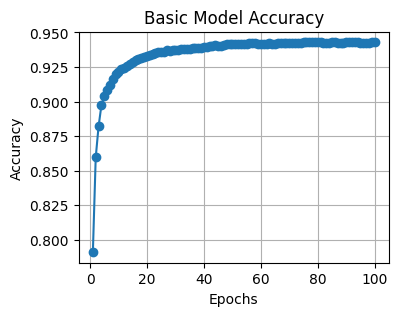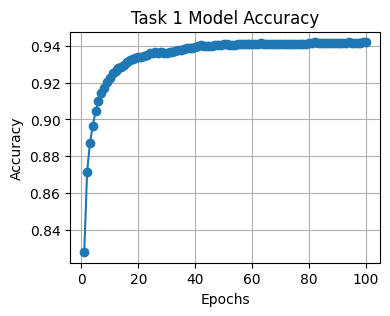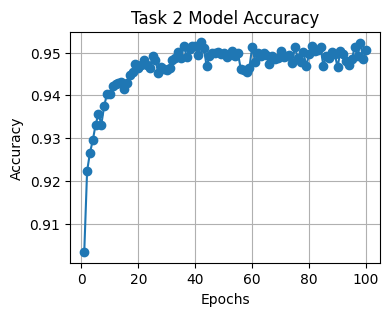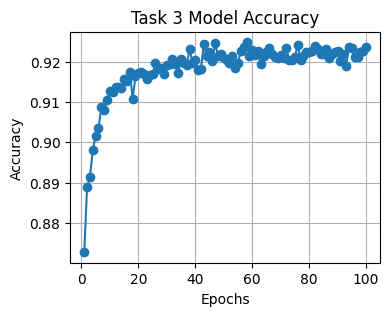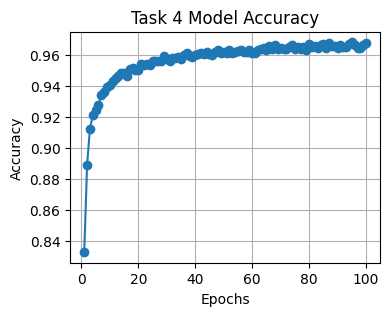